# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime
from collections import Counter
import time

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.patches as mpatches

In [3]:
# If GPU is available, then the code will be pushed to it otherwise it will move to CPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Location

## Pre-processing

In [ ]:
store_file_name ='store_final.csv'
sales_file_name ='sales_store_wise_1.csv'
store_data_frame = pd.read_csv(store_file_name)
sales_data_frame = pd.read_csv(sales_file_name)
# to the data frame "sales_data_frame", add an extra column called "CITY_NAME" by matching the STORE_NUMBER of sales_data_frame with store_data_frame, and extract the corresponding row's value under the field "CITY_NAME" from store_data_frame and put it as additional column in sales_data_frame

# Create a dictionary mapping STORE_NUMBER to CITY_NAME
store_city_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['CITY_NAME']))
store_state_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['STATE_NAME']))

# Add the CITY_NAME column to sales_data_frame
sales_data_frame['CITY_NAME'] = sales_data_frame['STORE_NUMBER'].map(store_city_mapping)
sales_data_frame['STATE_NAME'] = sales_data_frame['STORE_NUMBER'].map(store_state_mapping)

sales_data_frame['START_DATE'] = pd.to_datetime(sales_data_frame['START_DATE'])
# sales_data_frame.sort_values(['STATE_NAME'], inplace=True, ascending = True)
sales_data_frame = sales_data_frame.sort_values(['START_DATE'], ascending = True).groupby("STATE_NAME")

# sales_data_frame = sales_data_frame.groupby("STATE_NAME").apply(lambda x: x.sort_values("START_DATE", ascending = True)).reset_index(drop=True)
# sales_data_frame = sales_data_frame.apply(lambda x: x.sort_values(["START_DATE"])).groupby("STATE_NAME")
# sales_data_frame = sales_data_frame.apply(lambda x: x.sort_values(["START_DATE"])).groupby("STATE_NAME")

# sales_data_frame.groupby("STATE_NAME")
# sales_data_frame.dropna(inplace=True)
sales_data_frame.head()

<ipython-input-33-ae679f6d5d93>:15: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales_data_frame['START_DATE'] = pd.to_datetime(sales_data_frame['START_DATE'])


STORE_NUMBER   OPEN_DATE  MONTH_ORDER START_DATE    END_DATE  \
0                  2  09-05-1998         1713 2019-04-23  23-04-2019   
22403             94  29-01-2003         1713 2019-04-23  23-04-2019   
356626          1185  27-07-2016         1713 2019-04-23  23-04-2019   
354912          1180  14-12-2016         1713 2019-04-23  23-04-2019   
353198          1179  06-10-2017         1713 2019-04-23  23-04-2019   
...              ...         ...          ...        ...         ...   
501634          1547  11-03-2020         1390 2020-03-11  11-03-2020   
501635          1547  11-03-2020         1389 2020-03-12  12-03-2020   
501636          1547  11-03-2020         1388 2020-03-13  13-03-2020   
501637          1547  11-03-2020         1387 2020-03-14  14-03-2020   
501638          1547  11-03-2020         1386 2020-03-15  15-03-2020   

        TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  CITY_NAME  \
0                           109                     1809.84     IRVING   
22403                       226                     3734.59     AURORA   
356626                      193                     3079.69    MEDFORD   
354912                       97                     1214.51     SMYRNA   
353198                      103                     1732.85      TAMPA   
...                         ...                         ...        ...   
501634                      408                     7580.33  BEAVERTON   
501635                      449                     7939.67  BEAVERTON   
501636                      505                     9359.40  BEAVERTON   
501637                      447                     9231.11  BEAVERTON   
501638                      398                     9128.21  BEAVERTON   

           STATE_NAME  
0               Texas  
22403        Colorado  
356626  Massachusetts  
354912        Georgia  
353198        Florida  
...               ...  
501634         Oregon  
501635         Oregon  
501636         Oregon  
501637         Oregon  
501638         Oregon  

[190 rows x 9 columns]

In [7]:
store_file_name ='store.csv'
sales_file_name ='sales_data_with_city_datewise.csv'
store_data_frame = pd.read_csv(store_file_name)
sales_data_frame = pd.read_csv(sales_file_name)
# to the data frame "sales_data_frame", add an extra column called "CITY_NAME" by matching the STORE_NUMBER of sales_data_frame with store_data_frame, and extract the corresponding row's value under the field "CITY_NAME" from store_data_frame and put it as additional column in sales_data_frame

# Create a dictionary mapping STORE_NUMBER to CITY_NAME
store_statecode_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['STATE_CODE']))
store_dmaid_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['DMA_ID']))
store_dmaname_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['DMA_NAME']))
store_regid_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['REGION_ID']))
store_regname_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['REGION_NAME']))
store_areareg_mapping = dict(zip(store_data_frame['STORE_NUMBER'], store_data_frame['AREA_REGION']))

# Add the CITY_NAME column to sales_data_frame
sales_data_frame['STATE_CODE'] = sales_data_frame['STORE_NUMBER'].map(store_statecode_mapping)
sales_data_frame['DMA_ID'] = sales_data_frame['STORE_NUMBER'].map(store_dmaid_mapping)
sales_data_frame['DMA_NAME'] = sales_data_frame['STORE_NUMBER'].map(store_dmaname_mapping)
sales_data_frame['REGION_ID'] = sales_data_frame['STORE_NUMBER'].map(store_regid_mapping)
sales_data_frame['REGION_NAME'] = sales_data_frame['STORE_NUMBER'].map(store_regname_mapping)
sales_data_frame['AREA_REGION'] = sales_data_frame['STORE_NUMBER'].map(store_areareg_mapping)

# sales_data_frame['START_DATE'] = pd.to_datetime(sales_data_frame['START_DATE'])
# # sales_data_frame.sort_values(['STATE_NAME'], inplace=True, ascending = True)
sales_data_frame.sort_values(['START_DATE'], ascending = True).groupby("STATE_NAME")

# sales_data_frame = sales_data_frame.groupby("STATE_NAME").apply(lambda x: x.sort_values("START_DATE", ascending = True)).reset_index(drop=True)
# sales_data_frame = sales_data_frame.apply(lambda x: x.sort_values(["START_DATE"])).groupby("STATE_NAME")
# sales_data_frame = sales_data_frame.apply(lambda x: x.sort_values(["START_DATE"])).groupby("STATE_NAME")

# sales_data_frame.groupby("STATE_NAME")
# sales_data_frame.dropna(inplace=True)
sales_data_frame.head()

STORE_NUMBER   OPEN_DATE  MONTH_ORDER  START_DATE    END_DATE  \
0          1209  19-04-2017         1713  23-04-2019  23-04-2019   
1          1225  05-03-2017         1713  23-04-2019  23-04-2019   
2          1443  09-05-2018         1713  23-04-2019  23-04-2019   
3          1111  30-05-2016         1713  23-04-2019  23-04-2019   
4          1300  10-05-2017         1713  23-04-2019  23-04-2019   

   TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  CITY_NAME STATE_NAME  \
0                      114                     1670.86     MOBILE    Alabama   
1                      142                     2476.70  ANCHORAGE     Alaska   
2                       87                     1841.70    WASILLA     Alaska   
3                       94                     1702.92    BUCKEYE    Arizona   
4                      139                     2311.80   GLENDALE    Arizona   

  STATE_CODE  DMA_ID                    DMA_NAME  REGION_ID REGION_NAME  \
0         AL   686.0  MOBILE-PENSACOLA (FT WALT)        2.0   Southeast   
1         AK   743.0                   ANCHORAGE        4.0        West   
2         AK   743.0                   ANCHORAGE        4.0        West   
3         AZ   753.0          PHOENIX (PRESCOTT)        1.0   Southwest   
4         AZ   753.0          PHOENIX (PRESCOTT)        1.0   Southwest   

                  AREA_REGION  
0  MOBILE-PENSACOLA (FT WALT)  
1                   ANCHORAGE  
2                   ANCHORAGE  
3          PHOENIX (PRESCOTT)  
4          PHOENIX (PRESCOTT)

In [8]:
sales_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563113 entries, 0 to 563112
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   STORE_NUMBER                563113 non-null  int64  
 1   OPEN_DATE                   563113 non-null  object 
 2   MONTH_ORDER                 563113 non-null  int64  
 3   START_DATE                  563113 non-null  object 
 4   END_DATE                    563113 non-null  object 
 5   TRANSACTION_FINAL_COUNT     563113 non-null  int64  
 6   NET_SALES_FINAL_USD_AMOUNT  563113 non-null  float64
 7   CITY_NAME                   563113 non-null  object 
 8   STATE_NAME                  563113 non-null  object 
 9   STATE_CODE                  563113 non-null  object 
 10  DMA_ID                      563113 non-null  float64
 11  DMA_NAME                    563113 non-null  object 
 12  REGION_ID                   563113 non-null  float64
 13  REGION_NAME   

In [9]:
sales_data_frame.to_csv("sales_data_with_city_datewise_final.csv", index=False)

## EDA

 Info about the dataset

* The dataset has four location tags for each store namely
  1. City
  2. state Code, State Name
  3. DMA ID, DMA Name
  4. Region Name

* Storewise sales analysis is made at each of these levels such as city, state, dma and region.

* A DMA (Designated Market Area) is a geographic region used in the United States commonly used in media and advertising to segment the U.S. market for TV viewership and ad targeting. However, DMA can also be applied to sales, marketing, and logistics analysis.

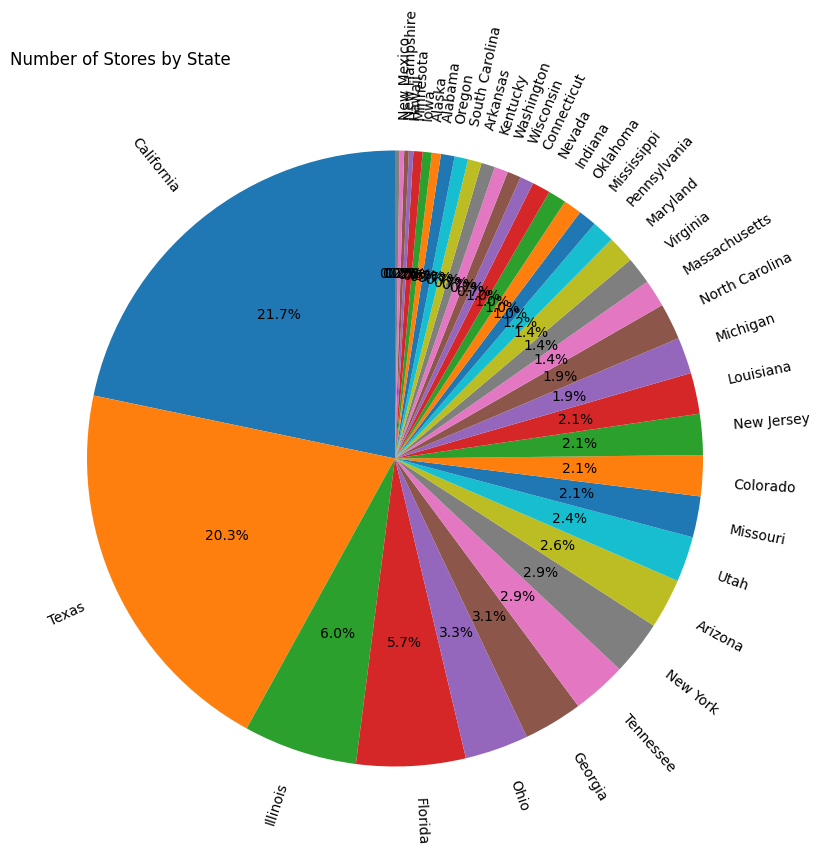

In [13]:
sales_city_datewise = pd.read_csv("sales_data_with_city_datewise_final.csv")
# Group by 'STORE_NUMBER' and get the first 'STATE_NAME' for each store
store_states = sales_city_datewise.groupby('STORE_NUMBER')['STATE_NAME'].first()

# Count the number of stores in each state
state_store_counts = store_states.value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(state_store_counts, labels=state_store_counts.index, autopct='%1.1f%%', startangle=90, rotatelabels=True)
plt.title('Number of Stores by State', loc='left')
plt.show()


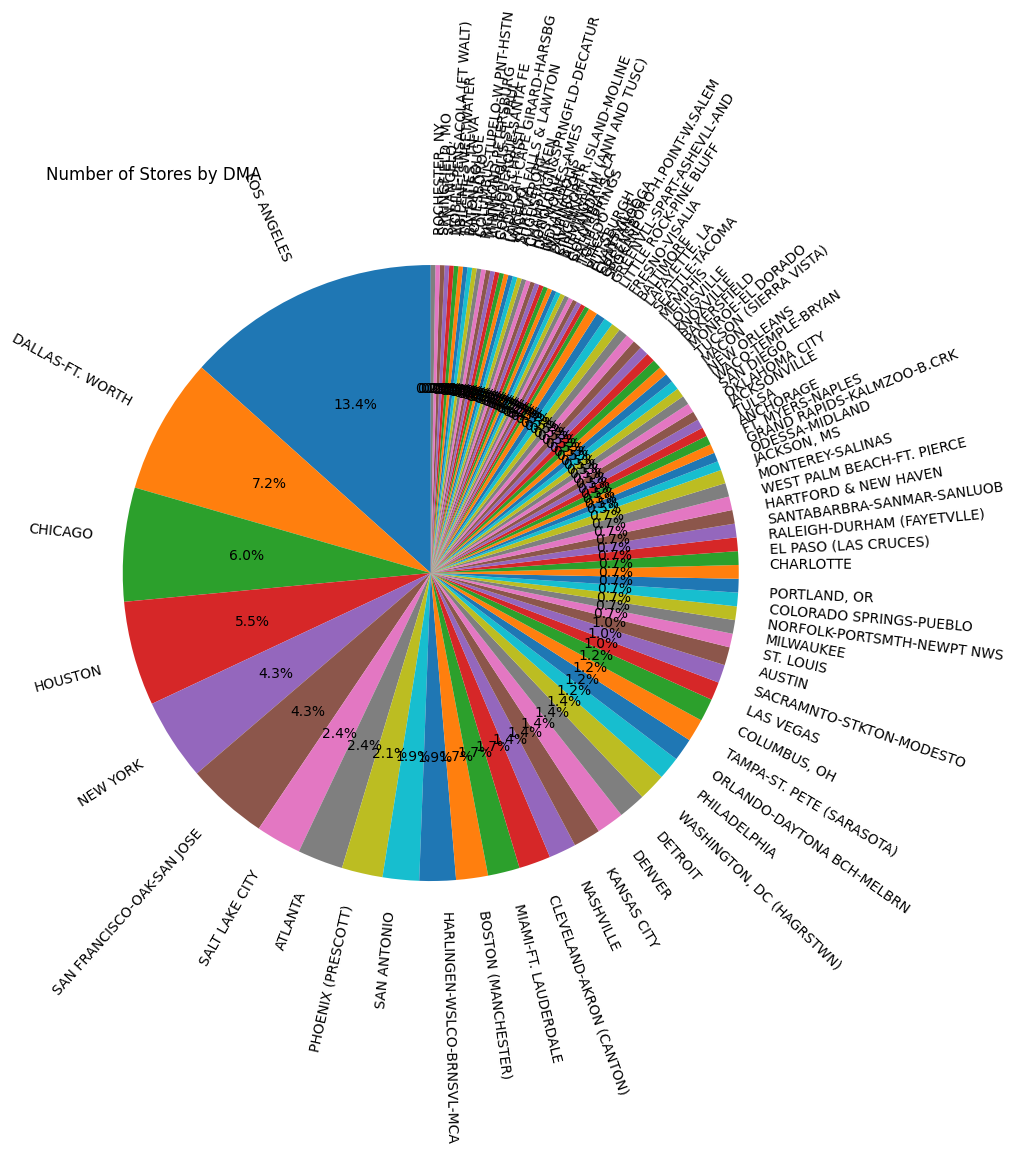

In [16]:
sales_city_datewise = pd.read_csv("sales_data_with_city_datewise_final.csv")
# Group by 'STORE_NUMBER' and get the first 'STATE_NAME' for each store
store_states = sales_city_datewise.groupby('STORE_NUMBER')['DMA_NAME'].first()

# Count the number of stores in each state
state_store_counts = store_states.value_counts()

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(state_store_counts, labels=state_store_counts.index, autopct='%1.1f%%', startangle=90, rotatelabels=True)
plt.title('Number of Stores by DMA', loc='left')
plt.show()


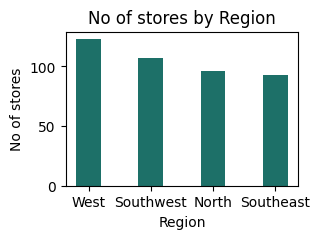

In [26]:
import matplotlib.pyplot as plt
sales_city_datewise = pd.read_csv("sales_data_with_city_datewise_final.csv")
# Group by 'STORE_NUMBER' and get the first 'STATE_NAME' for each store
store_states = sales_city_datewise.groupby('STORE_NUMBER')['REGION_NAME'].first()

# Count the number of stores in each state
state_store_counts = store_states.value_counts()

# # Create a pie chart
# plt.figure(figsize=(10, 10))
# plt.pie(state_store_counts, labels=state_store_counts.index, autopct='%1.1f%%', startangle=90, rotatelabels=True)
# plt.title('Number of Stores by DMA', loc='left')
# plt.show()

plt.figure(figsize=(3, 2))

plt.bar(state_store_counts.index, state_store_counts.values, color="#1d7068", width=0.4)
plt.xlabel('Region')
plt.ylabel('No of stores')
_ = plt.title('No of stores by Region')

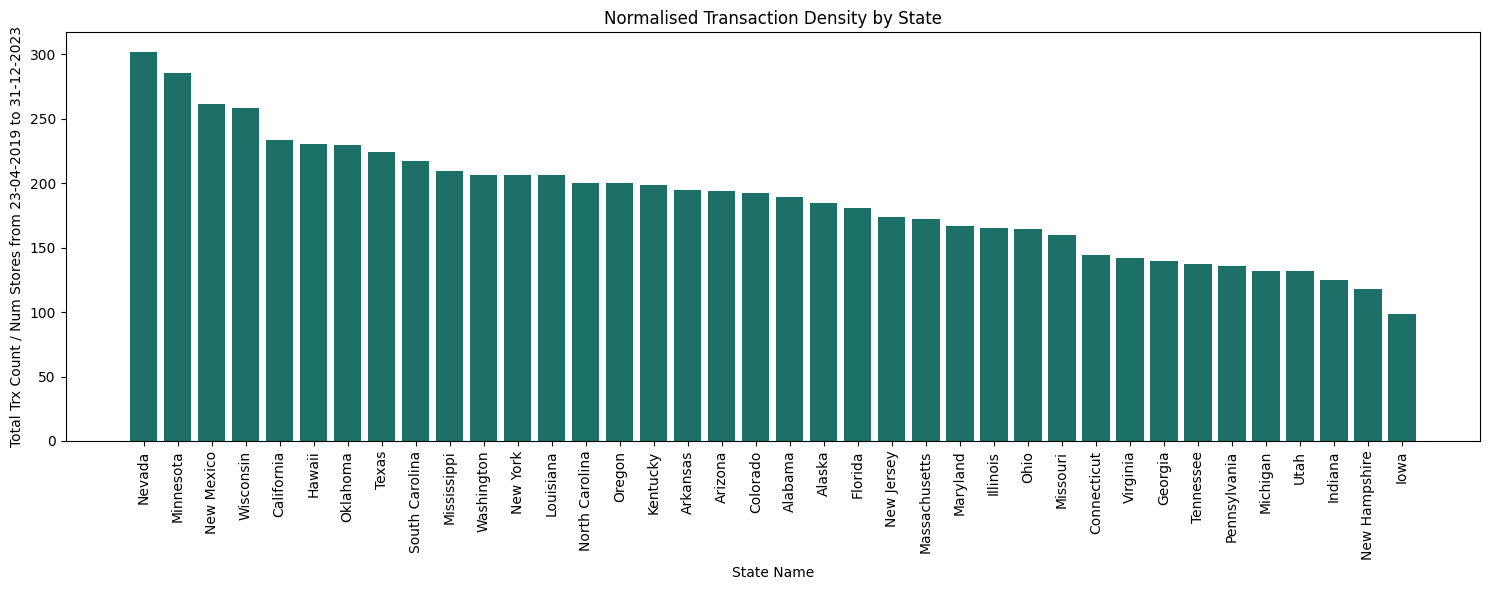

In [52]:
# Calculate total transactions and counts for each state
state_stats = sales_city_datewise.groupby('STATE_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']
state_stats.sort_values('ratio', ascending=False, inplace=True)
# Calculate the ratio
# state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['DATE']

# Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(state_stats.index, state_stats['TRANSACTION_FINAL_COUNT']/state_stats['OPEN_DATE'], color="#1d7068")


# Plotting the stacked bar graph
# state_stats.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])

# Annotate the bars
# for bar in bars:
#   height = bar.get_height()
#   # label_text = f"Total: {state_stats.loc[bar.get_x(), 'TRANSACTION_FINAL_COUNT']}\nCount: {state_stats.loc[bar.get_x(), 'DATE']}"
#   label_text = f"{height}"
#   plt.text(bar.get_x() + bar.get_width() / 2, height, label_text, ha='center', va='bottom')

# Set labels and title
plt.xlabel('State Name')
plt.ylabel('Total Trx Count / Num Stores from 23-04-2019 to 31-12-2023')
plt.title('Normalised Transaction Density by State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



In [48]:
state_stats

CITY_NAME  TRANSACTION_FINAL_COUNT  OPEN_DATE       ratio
0          SALINAS                   838217       1714  489.041424
1        SANTA ANA                   753554       1627  463.155501
2           LAREDO                   778159       1714  454.001750
3  NORTH LAS VEGAS                   738468       1714  430.844807
4           IRVINE                   700068       1714  408.441074
5           Eugene                    17509         47  372.531915
6         VAN NUYS                   618271       1714  360.718203
7     GARDEN GROVE                   591528       1714  345.115519
8           Saugus                     4756         14  339.714286
9           ODESSA                   572327       1714  333.913069

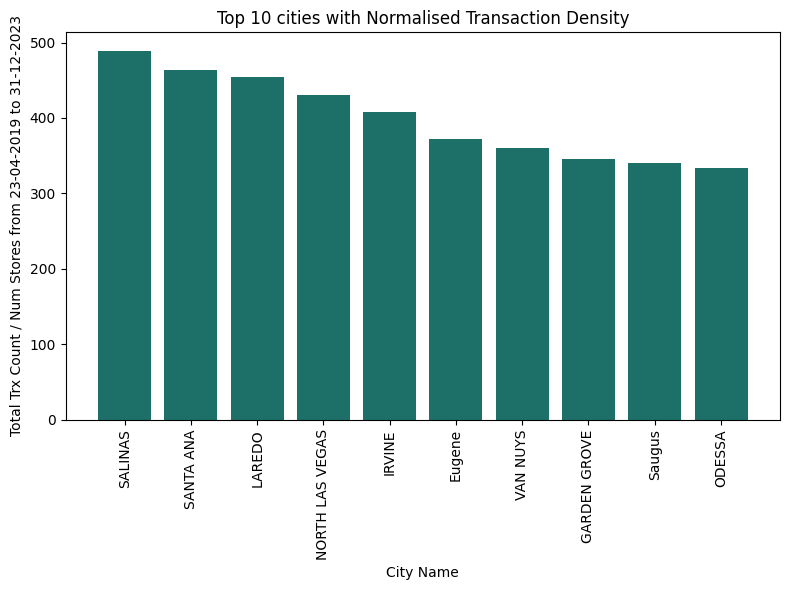

In [49]:
# Calculate total transactions and counts for each state
state_stats = sales_city_datewise.groupby('CITY_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']


# Create the bar plot
plt.figure(figsize=(8, 6))
# Display top 10 cities with highest state_stats['TRANSACTION_FINAL_COUNT']/state_stats['OPEN_DATE']
state_stats.sort_values("ratio", ascending=False, inplace=True)
# state_stats.reset_index(inplace=True)
state_stats = state_stats.head(10)


bars = plt.bar(state_stats.index, state_stats['ratio'], color="#1d7068")
# Set labels and title
plt.xlabel('City Name')
plt.ylabel('Total Trx Count / Num Stores from 23-04-2019 to 31-12-2023')
plt.title('Top 10 cities with Normalised Transaction Density')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

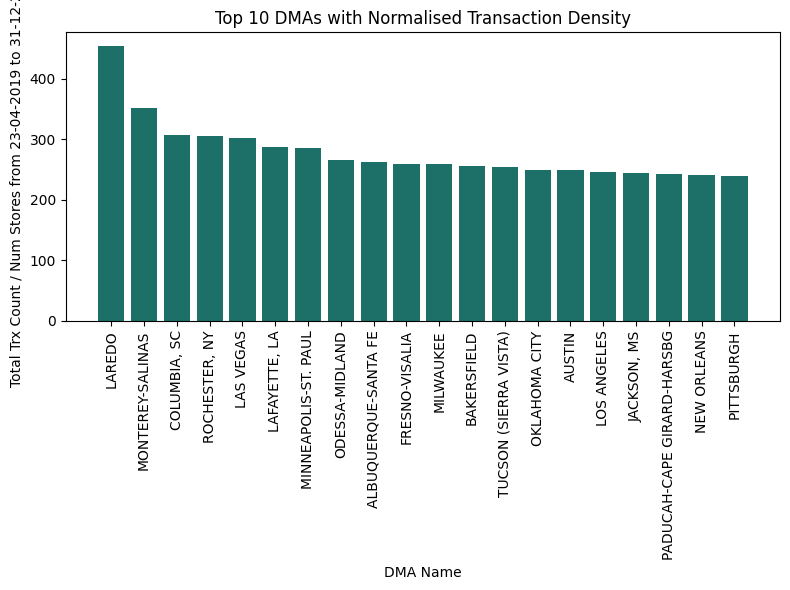

In [55]:
# Calculate total transactions and counts for each state
state_stats = sales_city_datewise.groupby('DMA_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']


# Create the bar plot
plt.figure(figsize=(8, 6))
# Display top 10 cities with highest state_stats['TRANSACTION_FINAL_COUNT']/state_stats['OPEN_DATE']
state_stats.sort_values("ratio", ascending=False, inplace=True)
# state_stats.reset_index(inplace=True)
state_stats = state_stats.head(20)


bars = plt.bar(state_stats.index, state_stats['ratio'], color="#1d7068")
# Set labels and title
plt.xlabel('DMA Name')
plt.ylabel('Total Trx Count / Num Stores from 23-04-2019 to 31-12-2023')
plt.title('Top 10 DMAs with Normalised Transaction Density')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

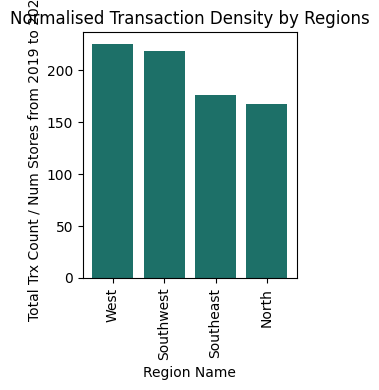

In [59]:
# Calculate total transactions and counts for each state
state_stats = sales_city_datewise.groupby('REGION_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']


# Create the bar plot
plt.figure(figsize=(3, 4))
# Display top 10 cities with highest state_stats['TRANSACTION_FINAL_COUNT']/state_stats['OPEN_DATE']
state_stats.sort_values("ratio", ascending=False, inplace=True)
# state_stats.reset_index(inplace=True)
state_stats = state_stats.head(10)


bars = plt.bar(state_stats.index, state_stats['ratio'], color="#1d7068")
# Set labels and title
plt.xlabel('Region Name')
plt.ylabel('Total Trx Count / Num Stores from 2019 to 2023')
plt.title('Normalised Transaction Density by Regions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [61]:
# prompt: # Calculate total transactions and counts for each state
# state_stats = sales_city_datewise.groupby('DMA_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
# group by DMAs and find sum of "NET_SALES_FINAL_USD_AMOUNT". also in eac group arrange in descending order of NET_SALES_FINAL_USD_AMOUNT and find the record in sales_city_datewise that had highest NET_SALES_FINAL_USD_AMOUNT in the group

# Calculate total transactions and counts for each DMA
dma_stats = sales_city_datewise.groupby('DMA_NAME')['NET_SALES_FINAL_USD_AMOUNT'].sum()

# Sort DMAs by total net sales in descending order
dma_stats_sorted = dma_stats.sort_values(ascending=False)

# Print the sorted DMA statistics
print(dma_stats_sorted)

# Find the record with the highest NET_SALES_FINAL_USD_AMOUNT in each DMA group
def find_highest_sales_record(group):
    return group.loc[group['NET_SALES_FINAL_USD_AMOUNT'].idxmax()]

highest_sales_records = sales_city_datewise.groupby('DMA_NAME').apply(find_highest_sales_record)

# Print the highest sales records
highest_sales_records

DMA_NAME
LOS ANGELES                   4.669653e+08
DALLAS-FT. WORTH              2.424745e+08
HOUSTON                       1.543783e+08
CHICAGO                       1.064066e+08
NEW YORK                      9.232763e+07
                                  ...     
SPOKANE                       1.230277e+06
GRAND RAPIDS-KALMZOO-B.CRK    9.196171e+05
NEW ORLEANS                   6.944286e+05
ROCHESTER, NY                 2.174655e+05
INDIANAPOLIS                  2.942241e+04
Name: NET_SALES_FINAL_USD_AMOUNT, Length: 98, dtype: float64


<ipython-input-61-22c71a0ca0e0>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  highest_sales_records = sales_city_datewise.groupby('DMA_NAME').apply(find_highest_sales_record)


STORE_NUMBER   OPEN_DATE  MONTH_ORDER  START_DATE  \
DMA_NAME                                                                        
ABILENE-SWEETWATER                  1151  15-06-2016          322  12-02-2023   
ALBUQUERQUE-SANTA FE                 488  14-08-2009          322  12-02-2023   
ALEXANDRIA, LA                      1974  17-01-2022          713  17-01-2022   
ANCHORAGE                           1225  05-03-2017          322  12-02-2023   
ATLANTA                             2037  07-12-2021          155  29-07-2023   
...                                  ...         ...          ...         ...   
WACO-TEMPLE-BRYAN                   1717  08-07-2020           99  23-09-2023   
WASHINGTON, DC (HAGRSTWN)            737  17-06-2014          322  12-02-2023   
WEST PALM BEACH-FT. PIERCE          1466  20-11-2018          322  12-02-2023   
WICHITA FALLS & LAWTON               123  17-09-2003          322  12-02-2023   
WILMINGTON                          1413  26-02-2018          322  12-02-2023   

                              END_DATE  TRANSACTION_FINAL_COUNT  \
DMA_NAME                                                          
ABILENE-SWEETWATER          12-02-2023                      367   
ALBUQUERQUE-SANTA FE        12-02-2023                      414   
ALEXANDRIA, LA              17-01-2022                      499   
ANCHORAGE                   12-02-2023                      422   
ATLANTA                     29-07-2023                      490   
...                                ...                      ...   
WACO-TEMPLE-BRYAN           23-09-2023                      729   
WASHINGTON, DC (HAGRSTWN)   12-02-2023                      481   
WEST PALM BEACH-FT. PIERCE  12-02-2023                      291   
WICHITA FALLS & LAWTON      12-02-2023                      262   
WILMINGTON                  12-02-2023                      400   

                            NET_SALES_FINAL_USD_AMOUNT        CITY_NAME  \
DMA_NAME                                                                  
ABILENE-SWEETWATER                            11717.19          ABILENE   
ALBUQUERQUE-SANTA FE                          16313.73      ALBUQUERQUE   
ALEXANDRIA, LA                                10831.61       Alexandria   
ANCHORAGE                                     17915.17        ANCHORAGE   
ATLANTA                                       10813.96           Buford   
...                                                ...              ...   
WACO-TEMPLE-BRYAN                             15083.36  COLLEGE STATION   
WASHINGTON, DC (HAGRSTWN)                     18729.45    SILVER SPRING   
WEST PALM BEACH-FT. PIERCE                    11000.37       GREENACRES   
WICHITA FALLS & LAWTON                        10067.97    WICHITA FALLS   
WILMINGTON                                    11625.57       WILMINGTON   

                                STATE_NAME STATE_CODE  DMA_ID  \
DMA_NAME                                                        
ABILENE-SWEETWATER                   Texas         TX   662.0   
ALBUQUERQUE-SANTA FE            New Mexico         NM   790.0   
ALEXANDRIA, LA                   Louisiana         LA   644.0   
ANCHORAGE                           Alaska         AK   743.0   
ATLANTA                            Georgia         GA   524.0   
...                                    ...        ...     ...   
WACO-TEMPLE-BRYAN                    Texas         TX   625.0   
WASHINGTON, DC (HAGRSTWN)         Maryland         MD   511.0   
WEST PALM BEACH-FT. PIERCE         Florida         FL   548.0   
WICHITA FALLS & LAWTON               Texas         TX   627.0   
WILMINGTON                  North Carolina         NC   550.0   

                                              DMA_NAME  REGION_ID REGION_NAME  \
DMA_NAME                                                                        
ABILENE-SWEETWATER                  ABILENE-SWEETWATER        1.0   Southwest   
ALBUQUERQUE-SANTA FE              ALB

In [65]:
import pandas as pd

# Create the table
table_data = []

# Group by DMA_NAME
for dma_name, group in sales_city_datewise.groupby('DMA_NAME'):
  # Calculate total NET_SALES_FINAL_USD_AMOUNT
  total_net_sales = group['NET_SALES_FINAL_USD_AMOUNT'].sum()
  # Find the highest store number within the DMA group
  highest_store = group['STORE_NUMBER'].max()
  table_data.append({'DMA_NAME': dma_name, 'NET_SALES_FINAL_USD_AMOUNT': total_net_sales, 'HIGHEST_STORE_NUMBER': highest_store})

# Create DataFrame and print
result_df = pd.DataFrame(table_data)
result_df = result_df.sort_values(by='NET_SALES_FINAL_USD_AMOUNT', ascending=False)
result_df

DMA_NAME  NET_SALES_FINAL_USD_AMOUNT  \
49                 LOS ANGELES                4.669653e+08   
23            DALLAS-FT. WORTH                2.424745e+08   
38                     HOUSTON                1.543783e+08   
15                     CHICAGO                1.064066e+08   
61                    NEW YORK                9.232763e+07   
..                         ...                         ...   
84                     SPOKANE                1.230277e+06   
32  GRAND RAPIDS-KALMZOO-B.CRK                9.196171e+05   
60                 NEW ORLEANS                6.944286e+05   
74               ROCHESTER, NY                2.174655e+05   
39                INDIANAPOLIS                2.942241e+04   

    HIGHEST_STORE_NUMBER  
49                  2574  
23                  2255  
38                  2389  
15                  2422  
61                  2285  
..                   ...  
84                  2263  
32                  2414  
60                  2490  
74                  2470  
39                   785  

[98 rows x 3 columns]

In [ ]:
# Calculate total transactions and counts for each state
state_stats = sales_city_datewise.groupby('DMA_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})


# Create the bar plot
plt.figure(figsize=(3, 4))
# Display top 10 cities with highest state_stats['TRANSACTION_FINAL_COUNT']/state_stats['OPEN_DATE']
state_stats.sort_values("ratio", ascending=False, inplace=True)
# state_stats.reset_index(inplace=True)
state_stats = state_stats.head(10)


bars = plt.bar(state_stats.index, state_stats['ratio'], color="#1d7068")
# Set labels and title
plt.xlabel('Region Name')
plt.ylabel('Total Trx Count / Num Stores from 2019 to 2023')
plt.title('Normalised Transaction Density by Regions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [60]:
# # Group the DataFrame by 'STATE_NAME'
# grouped = sales_city_datewise.groupby('STATE_NAME')

# # Find the highest amount and corresponding details for each state
# result = []
# for state, group in grouped:
#   highest_amount_row = group.loc[group['HIGHEST_AMOUNT'].idxmax()]
#   result.append({
#       'STATE_NAME': state,
#       'HIGHEST_AMOUNT': highest_amount_row['HIGHEST_AMOUNT'],
#       'HIGHEST_AMOUNT_STORE': highest_amount_row['HIGHEST_AMOUNT_STORE'],
#       'DATE': highest_amount_row['DATE']
#   })

# # Create a DataFrame from the result
# result_df = pd.DataFrame(result)

# print(result_df)


KeyError: 'HIGHEST_AMOUNT'

In [ ]:
# Group the DataFrame by 'STATE_NAME' and get the mode of 'HIGHEST_AMOUNT_STORE_CITY' for each state
mode_cities = new_data_frame_sales_state_datewise.groupby('STATE_NAME')['HIGHEST_AMOUNT_STORE_CITY'].agg(pd.Series.mode)

# Create a new DataFrame from the result
result_df = pd.DataFrame({
    'STATE_NAME': mode_cities.index,
    'MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY': mode_cities.values
})

# Merge with original DataFrame to get 'REGION_NAME'
result_df = result_df.merge(new_data_frame_sales_state_datewise[['STATE_NAME', 'REGION_NAME']].drop_duplicates(), on='STATE_NAME', how='left')

# Print the resulting DataFrame
print(result_df)


        STATE_NAME MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY REGION_NAME
0          Alabama                                   MOBILE   Southeast
1           Alaska                                ANCHORAGE        West
2          Arizona                                   TUCSON   Southwest
3         Arkansas                              LITTLE ROCK   Southeast
4       California                                  SALINAS        West
5         Colorado                                   AURORA        West
6      Connecticut                                 HARTFORD       North
7          Florida                                  BRANDON   Southeast
8          Georgia                                  AUGUSTA   Southeast
9           Hawaii                                 MILILANI        West
10        Illinois                                  CHICAGO       North
11         Indiana                                   HOBART       North
12            Iowa                                     AMES     

# Modelling with location


## Geospatial Analysis

In [ ]:
!pip install geopy folium

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
import time


# Initialize the geolocator with increased timeout
geolocator = Nominatim(user_agent="store_locator", timeout=10)

# Function to get latitude and longitude with retries
def get_lat_lon(city):
    try:
        location = geolocator.geocode(city)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        print(f"Timeout error for {city}. Retrying...")
        time.sleep(1)
        return get_lat_lon(city)
    except Exception as e:
        print(f"Error for {city}: {e}")
        return None, None

# Get latitude and longitude for each city
result_df[['Latitude', 'Longitude']] = result_df['MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY'].apply(lambda x: pd.Series(get_lat_lon(x)))

# Drop rows with missing latitude or longitude
result_df = result_df.dropna(subset=['Latitude', 'Longitude'])

# Create a map centered around the first store's location
map_center = [result_df.iloc[0]['Latitude'], result_df.iloc[0]['Longitude']]
store_map = folium.Map(location=map_center, zoom_start=5)

# Add points to the map
for idx, row in result_df.iterrows():
    location = (row['Latitude'], row['Longitude'])
    color = 'blue'
    tooltip = result_df.loc[idx, 'MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY']
    folium.CircleMarker(location=location, radius=2, color=color, fill=True, tooltip=tooltip).add_to(store_map)

# Save the map to an HTML file
# store_map.save('/content/drive/My Drive/store_map.html')

store_map

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
import time

# Initialize the geolocator with increased timeout
geolocator = Nominatim(user_agent="store_locator", timeout=10)

# Function to get latitude and longitude with retries
def get_lat_lon(city):
    try:
        location = geolocator.geocode(city)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        print(f"Timeout error for {city}. Retrying...")
        time.sleep(1)
        return get_lat_lon(city)
    except Exception as e:
        print(f"Error for {city}: {e}")
        return None, None

# Assuming result_df is already defined and has the necessary data
result_df[['Latitude', 'Longitude']] = result_df['MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY'].apply(lambda x: pd.Series(get_lat_lon(x)))

# Drop rows with missing latitude or longitude
result_df = result_df.dropna(subset=['Latitude', 'Longitude'])

# Create a map centered around the first store's location
map_center = [result_df.iloc[0]['Latitude'], result_df.iloc[0]['Longitude']]
store_map = folium.Map(location=map_center, zoom_start=5)

# Add points to the map with permanent labels
for idx, row in result_df.iterrows():
    location = (row['Latitude'], row['Longitude'])
    city_name = row['MAX_OCCURRENCE_HIGHEST_AMOUNT_STORE_CITY']

    # Marker with a label
    folium.Marker(
        location=location,
        icon=folium.DivIcon(html=f'<div style="font-size: 10px; color: blue; bgcolor: white;">{city_name}</div>')
    ).add_to(store_map)

# Save the map to an HTML file
# store_map.save('/content/drive/My Drive/store_map.html')

store_map


In [141]:
import folium
import pandas as pd
import json
from urllib.request import urlopen

# Assuming state_stats is already defined as a DataFrame with "STATE_NAME" as the index and "TRANSACTION_FINAL_COUNT" as a column
state_stats = sales_city_datewise.groupby('STATE_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']

#Rename "OPEN_DATE" column to "NUM_OF_STORES"
state_stats.rename(columns={'OPEN_DATE': 'NUM_OF_STORES'}, inplace=True)

# Dictionary to map full state names to abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

state_stats.sort_values("TRANSACTION_FINAL_COUNT", ascending=False, inplace=True)
state_stats.reset_index(inplace=True)

# Replace full state names with abbreviations in the DataFrame
# state_stats = state_stats.reset_index()
state_stats['STATE_ABBREV'] = state_stats['STATE_NAME'].map(state_abbrev)

# Load the geojson file for US states
state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

In [86]:
state_stats

STATE_NAME  TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  \
0       California                 29443024                6.624411e+08   
1            Texas                 29377718                6.713808e+08   
2          Florida                  6624288                1.347417e+08   
3         Illinois                  5729217                1.139939e+08   
4          Arizona                  3086022                7.052601e+07   
5         New York                  3040748                6.477898e+07   
6             Ohio                  2972409                6.125061e+07   
7          Georgia                  2498177                4.899723e+07   
8         Colorado                  2366157                6.090751e+07   
9   North Carolina                  2309879                4.530456e+07   
10       Louisiana                  1997734                3.822401e+07   
11        Missouri                  1853578                3.696797e+07   
12        Maryland                  1708049                3.626402e+07   
13      New Jersey                  1610711                3.570712e+07   
14          Nevada                  1555591                3.474836e+07   
15       Tennessee                  1525385                3.131295e+07   
16     Mississippi                  1437953                2.644807e+07   
17        Oklahoma                  1250427                2.589237e+07   
18   Massachusetts                  1235140                2.518864e+07   
19            Utah                  1098051                2.589103e+07   
20        Arkansas                  1000329                2.003035e+07   
21        Michigan                   892745                1.842762e+07   
22  South Carolina                   815499                1.658272e+07   
23        Virginia                   804026                1.704136e+07   
24    Pennsylvania                   709846                1.450179e+07   
25        Kentucky                   680986                1.364718e+07   
26          Alaska                   633654                1.684189e+07   
27      Washington                   615599                1.456777e+07   
28       Wisconsin                   590055                1.240466e+07   
29         Alabama                   494865                9.667320e+06   
30       Minnesota                   488985                1.042743e+07   
31      New Mexico                   448416                1.135665e+07   
32         Indiana                   435748                9.217341e+06   
33          Hawaii                   394469                1.055701e+07   
34          Oregon                   342805                8.163249e+06   
35     Connecticut                   340996                6.697285e+06   
36            Iowa                   328517                6.306094e+06   
37   New Hampshire                   202697                4.334609e+06   

    NUM_OF_STORES       ratio STATE_ABBREV  
0          126226  233.256413           CA  
1          131228  223.867757           TX  
2           36589  181.045888           FL  
3           34750  164.869554           IL  
4           15938  193.626678           AZ  
5           14731  206.418302           NY  
6           18112  164.112688           OH  
7           17862  139.859870           GA  
8           12285  192.605372           CO  
9           11538  200.197521           NC  
10           9684  206.292235           LA  
11          11580  160.067185           MO  
12          10220  167.128082           MD  
13           9284  173.493214           NJ  
14           5152  301.939247           NV  
15          11093  137.508789           TN  
16           6856  209.736435           MS  
17           5450  229.436147           OK  
18           7157  172.577896           MA  
19           8326  131.882176           UT  
20           5142  194.540840           AR  
21           6762  132.023810           MI  
22           3748  217.582444           SC  
23

In [92]:
state_stats_2

STATE_NAME  TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  \
0       California                 29443024                6.624411e+08   
1            Texas                 29377718                6.713808e+08   
2          Florida                  6624288                1.347417e+08   
3         Illinois                  5729217                1.139939e+08   
4          Arizona                  3086022                7.052601e+07   
5         New York                  3040748                6.477898e+07   
6             Ohio                  2972409                6.125061e+07   
7          Georgia                  2498177                4.899723e+07   
8         Colorado                  2366157                6.090751e+07   
9   North Carolina                  2309879                4.530456e+07   
10       Louisiana                  1997734                3.822401e+07   
11        Missouri                  1853578                3.696797e+07   
12        Maryland                  1708049                3.626402e+07   
13      New Jersey                  1610711                3.570712e+07   
14          Nevada                  1555591                3.474836e+07   
15       Tennessee                  1525385                3.131295e+07   
16     Mississippi                  1437953                2.644807e+07   
17        Oklahoma                  1250427                2.589237e+07   
18   Massachusetts                  1235140                2.518864e+07   
19            Utah                  1098051                2.589103e+07   
20        Arkansas                  1000329                2.003035e+07   
21        Michigan                   892745                1.842762e+07   
22  South Carolina                   815499                1.658272e+07   
23        Virginia                   804026                1.704136e+07   
24    Pennsylvania                   709846                1.450179e+07   
25        Kentucky                   680986                1.364718e+07   
26          Alaska                   633654                1.684189e+07   
27      Washington                   615599                1.456777e+07   
28       Wisconsin                   590055                1.240466e+07   
29         Alabama                   494865                9.667320e+06   
30       Minnesota                   488985                1.042743e+07   
31      New Mexico                   448416                1.135665e+07   
32         Indiana                   435748                9.217341e+06   
33          Hawaii                   394469                1.055701e+07   
34          Oregon                   342805                8.163249e+06   
35     Connecticut                   340996                6.697285e+06   
36            Iowa                   328517                6.306094e+06   
37   New Hampshire                   202697                4.334609e+06   

    NUM_OF_STORES       ratio STATE_ABBREV   Latitude   Longitude  
0          126226  233.256413           CA  36.701463 -118.755997  
1          131228  223.867757           TX  31.263890  -98.545612  
2           36589  181.045888           FL  27.756767  -81.463983  
3           34750  164.869554           IL  40.079661  -89.433729  
4           15938  193.626678           AZ  34.395342 -111.763275  
5           14731  206.418302           NY  40.712728  -74.006015  
6           18112  164.112688           OH  40.225357  -82.688140  
7           17862  139.859870           GA  32.329381  -83.113737  
8           12285  192.605372           CO  38.725178 -105.607716  
9           11538  200.197521           NC  35.672964  -79.039292  
10           9684  206.292235           LA  30.870388  -92.007126  
11          11580  160.067185           MO  38.760481  -92.561787  
12          10220  167.128082           MD  39.516240  -76.938207  
13           9284  173.493214           NJ  40.075738  -74.404162  
14           5152  301.939247           NV  39.515882 -116.853

In [91]:
import plotly.graph_objects as go

# Assuming state_stats has the necessary data
fig = go.Figure(go.Choropleth(
    z=state_stats['TRANSACTION_FINAL_COUNT'],  # Color based on transaction count
    locations=state_stats['STATE_ABBREV'],  # Use state abbreviations
    locationmode="USA-states",  # Set location mode to US states
    colorscale="Viridis",  # Choose a color scale
    colorbar_title="Transaction Count",  # Color bar title
    hoverinfo="location+z",  # Show location and value on hover
))

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
import time

# Initialize the geolocator with increased timeout
geolocator = Nominatim(user_agent="store_locator", timeout=10)

# Function to get latitude and longitude with retries
def get_lat_lon(city):
    try:
        location = geolocator.geocode(city)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        print(f"Timeout error for {city}. Retrying...")
        time.sleep(1)
        return get_lat_lon(city)
    except Exception as e:
        print(f"Error for {city}: {e}")
        return None, None

# Assuming result_df is already defined and has the necessary data
state_stats[['Latitude', 'Longitude']] = state_stats['STATE_NAME'].apply(lambda x: pd.Series(get_lat_lon(x)))

# Drop rows with missing latitude or longitude
state_stats_2 = state_stats.dropna(subset=['Latitude', 'Longitude'])



In [99]:
import plotly.graph_objects as go

# Assuming state_stats has the necessary data
fig = go.Figure(go.Choropleth(
    z=state_stats['TRANSACTION_FINAL_COUNT'],  # Color based on transaction count
    locations=state_stats['STATE_ABBREV'],  # Use state abbreviations
    locationmode="USA-states",  # Set location mode to US states
    colorscale="Viridis",  # Choose a color scale
    colorbar_title="Transaction Count",  # Color bar title
    hoverinfo="location+z",  # Show location and value on hover
))

# Adding annotations for state names to always display them on the map
annotations = []
for i, row in state_stats.iterrows():
    annotations.append(
        dict(
            x=row['Longitude'],  # Longitude coordinate for state (if available)
            y=row['Latitude'],   # Latitude coordinate for state (if available)
            text=row['STATE_NAME'],  # State name
            showarrow=False,  # Don't show arrows for annotations
            font=dict(size=10, color='black'),
            align="center"
        )
    )

# Update layout to ensure state names are visible and set the title
fig.update_layout(
    title_text="Transaction Count Heatmap by State",
    geo=dict(
        scope="usa",  # Set scope to USA
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
    ),
    annotations=annotations  # Add state name annotations
)

fig.show()


In [145]:

!pip install plotly

import plotly.express as px

# Assuming you have a GeoJSON file with state boundaries (you can download one from various sources)
us_states = px.data.gapminder()
# Assuming 'state_stats' DataFrame has a column 'STATE_NAME' matching the state names in the GeoJSON

fig = px.choropleth(state_stats,
                    # locations=state_stats.index,  # Use state names as locations
                    locations=state_stats.STATE_ABBREV,  # Use state names as locations
                    locationmode="USA-states",  # Set location mode to US states
                    color="TRANSACTION_FINAL_COUNT",  # Color based on transaction count
                    scope="usa",  # Set scope to USA
                    color_continuous_scale="Viridis",  # Choose a color scale
                    title="Transaction Count Heatmap by State",
                    labels={'TRANSACTION_FINAL_COUNT': 'Transaction Count'},  # Label for color bar
                    hover_name="STATE_NAME",  # Display state name on hover
                    # text=state_stats['STATE_NAME']  # Add state name labels on the map
                   )

fig.show()


In [146]:

# Save the map to an HTML file
file_path = 'trans_count_map_with_legend.html'
fig.write_html(file_path)

# Optionally print the file path
print(f"Map saved to {file_path}")

Map saved to trans_count_map_with_legend.html


In [142]:
# Assuming you have a GeoJSON file with state boundaries (you can download one from various sources)
us_states = px.data.gapminder()
# Assuming 'state_stats' DataFrame has a column 'STATE_NAME' matching the state names in the GeoJSON

fig = px.choropleth(state_stats,
                    # locations=state_stats.index,  # Use state names as locations
                    locations=state_stats.STATE_ABBREV,  # Use state names as locations
                    locationmode="USA-states",  # Set location mode to US states
                    color="ratio",  # Color based on transaction count
                    scope="usa",  # Set scope to USA
                    color_continuous_scale="Viridis",  # Choose a color scale
                    title="Normalised Transaction Count per store Heatmap by State",
                    labels={'ratio': 'ratio'},  # Label for color bar
                    hover_name="STATE_NAME",  # Display state name on hover
                    # text=state_stats['STATE_NAME']  # Add state name labels on the map
                   )

fig.show()

In [144]:

# Save the map to an HTML file
file_path = 'norm_trans_map_with_legend.html'
fig.write_html(file_path)

# Optionally print the file path
print(f"Map saved to {file_path}")


Map saved to norm_trans_map_with_legend.html


In [88]:
# Assuming you have a GeoJSON file with state boundaries (you can download one from various sources)
us_states = px.data.gapminder()
# Assuming 'state_stats' DataFrame has a column 'STATE_NAME' matching the state names in the GeoJSON

fig = px.choropleth(state_stats,
                    # locations=state_stats.index,  # Use state names as locations
                    locations=state_stats.STATE_ABBREV,  # Use state names as locations
                    locationmode="USA-states",  # Set location mode to US states
                    color="ratio",  # Color based on transaction count
                    scope="usa",  # Set scope to USA
                    color_continuous_scale="Viridis",  # Choose a color scale
                    title="Normalised Transaction Count per store Heatmap by State",
                    labels={'ratio': 'ratio'},  # Label for color bar
                    hover_name="STATE_NAME",  # Display state name on hover
                    # text=state_stats['STATE_NAME']  # Add state name labels on the map
                   )

fig.show()

In [ ]:
region_stats = new_data_frame_sales_state_datewise.groupby('REGION_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum'})

In [ ]:
region_stats.head()

TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT
REGION_NAME                                                     
North                       20430721                4.201863e+08
Southeast                   21897170                4.382615e+08
Southwest                   34162583                7.791559e+08
West                        36449350                8.341179e+08

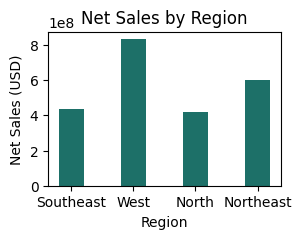

In [ ]:
# @title Net Sales by Region

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
regions = ['Southeast', 'West', 'North', 'Northeast']
net_sales = [438261483.29, 834117892.58, 420186348.96, 600000000]

plt.figure(figsize=(3, 2))
plt.bar(regions, net_sales, color="#1d7068", width=0.4)
plt.xlabel('Region')
plt.ylabel('Net Sales (USD)')
_ = plt.title('Net Sales by Region')

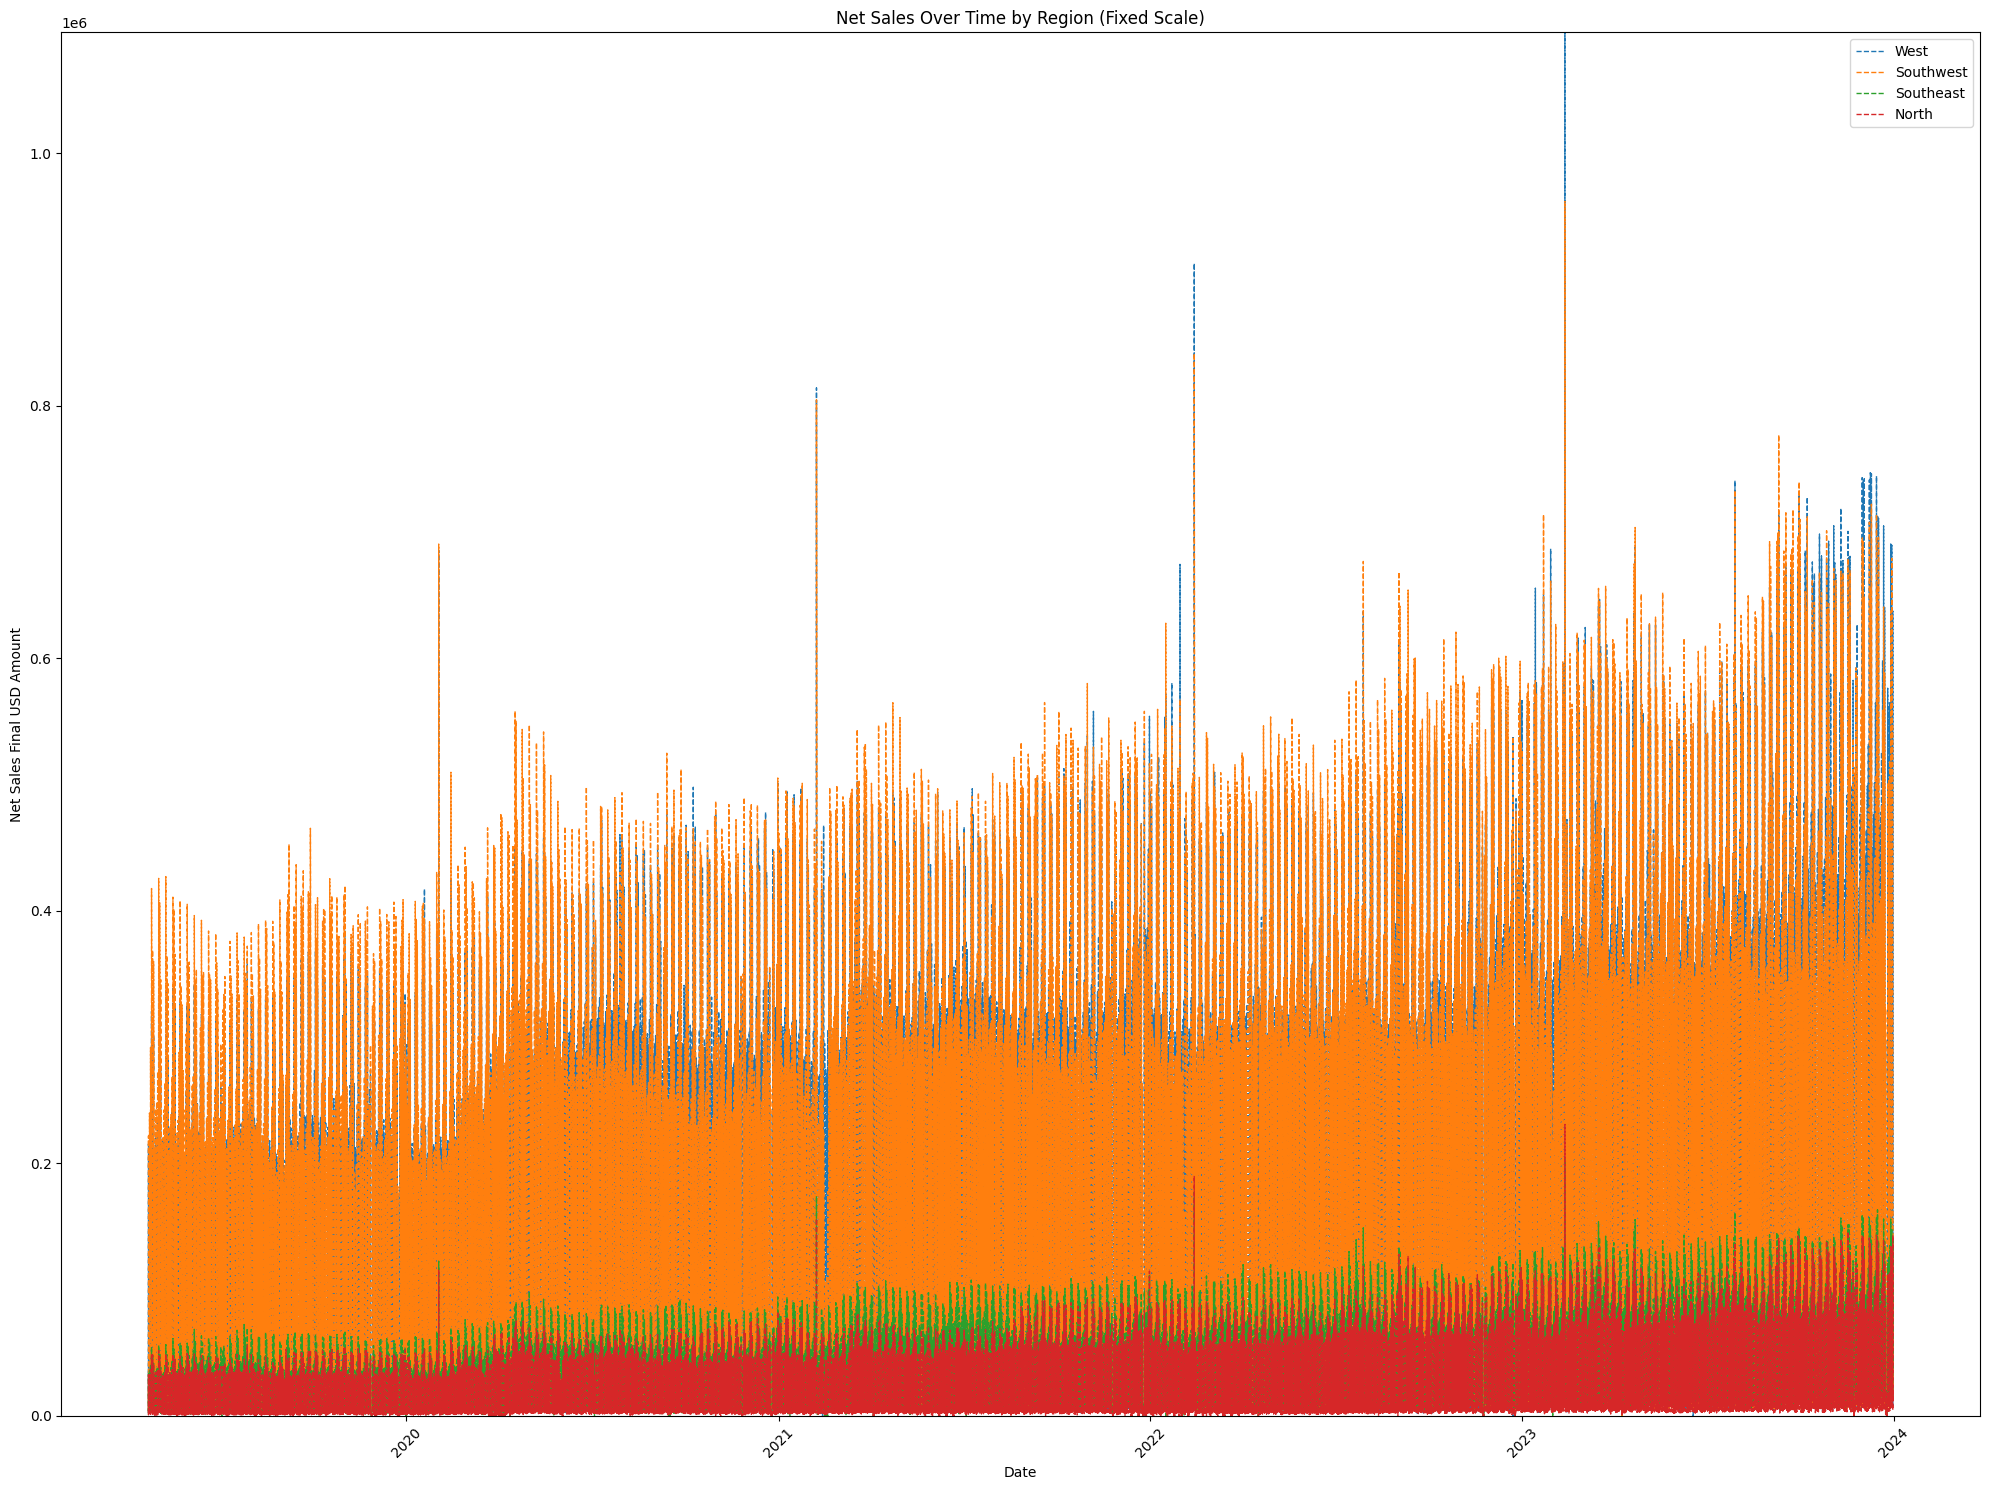

In [ ]:
# prompt: In "new_data_frame_sales_state_datewise", for every "REGION_NAME",  plot the "NET_SALES_FINAL_USD_AMOUNT" VS "DATE". In a single plot stack 4 plots (one for each region), all the 4 region wise plots should be in one plot, all plots should be on a fixed scale

# Group the DataFrame by 'REGION_NAME'
grouped = new_data_frame_sales_state_datewise.groupby('REGION_NAME')
region_order = ['West', 'Southwest', 'Southeast', 'North']

# Create a figure and axes with fixed scale
fig, ax = plt.subplots(figsize=(20, 15))
# Set y-axis limits based on the entire dataset
y_min = new_data_frame_sales_state_datewise['NET_SALES_FINAL_USD_AMOUNT'].min()
y_max = new_data_frame_sales_state_datewise['NET_SALES_FINAL_USD_AMOUNT'].max()
ax.set_ylim([y_min, y_max])

# Iterate over the groups and plot the data
# for region, group in grouped:
#     ax.plot(group['DATE'], group['NET_SALES_FINAL_USD_AMOUNT'], label=region, linewidth=1)

for i, region in enumerate(region_order):
    if region in grouped.groups:
        group = grouped.get_group(region)
        # axes[i].plot(group['DATE'], group['NET_SALES_FINAL_USD_AMOUNT'])
        # axes[i].set_title(region)
        ax.plot(group['DATE'], group['NET_SALES_FINAL_USD_AMOUNT'], label=region, linewidth=1, linestyle='dashed')


# Set the title and labels
ax.set_title('Net Sales Over Time by Region (Fixed Scale)')
ax.set_xlabel('Date')
ax.set_ylabel('Net Sales Final USD Amount')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [4]:
sales_city_datewise = pd.read_csv("sales_data_with_city_datewise_final.csv")

In [100]:
sales_city_datewise

STORE_NUMBER   OPEN_DATE  MONTH_ORDER  START_DATE    END_DATE  \
0               1209  19-04-2017         1713  23-04-2019  23-04-2019   
1               1225  05-03-2017         1713  23-04-2019  23-04-2019   
2               1443  09-05-2018         1713  23-04-2019  23-04-2019   
3               1111  30-05-2016         1713  23-04-2019  23-04-2019   
4               1300  10-05-2017         1713  23-04-2019  23-04-2019   
...              ...         ...          ...         ...         ...   
563108           748  17-09-2014            0  31-12-2023  31-12-2023   
563109          2263  19-04-2023            0  31-12-2023  31-12-2023   
563110          2496  21-12-2023            0  31-12-2023  31-12-2023   
563111          2198  24-06-2022            0  31-12-2023  31-12-2023   
563112           589  28-12-2011            0  31-12-2023  31-12-2023   

        TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT       CITY_NAME  \
0                           114                     1670.86          MOBILE   
1                           142                     2476.70       ANCHORAGE   
2                            87                     1841.70         WASILLA   
3                            94                     1702.92         BUCKEYE   
4                           139                     2311.80        GLENDALE   
...                         ...                         ...             ...   
563108                      336                     9971.32          RENTON   
563109                      104                     3123.07         Spokane   
563110                      133                     3543.41   Hales Corners   
563111                      193                     4810.01        Waukesha   
563112                      345                     9394.51  WEST MILWAUKEE   

        STATE_NAME STATE_CODE  DMA_ID                    DMA_NAME  REGION_ID  \
0          Alabama         AL   686.0  MOBILE-PENSACOLA (FT WALT)        2.0   
1           Alaska         AK   743.0                   ANCHORAGE        4.0   
2           Alaska         AK   743.0                   ANCHORAGE        4.0   
3          Arizona         AZ   753.0          PHOENIX (PRESCOTT)        1.0   
4          Arizona         AZ   753.0          PHOENIX (PRESCOTT)        1.0   
...            ...        ...     ...                         ...        ...   
563108  Washington         WA   819.0              SEATTLE-TACOMA        4.0   
563109  Washington         WA   881.0                     SPOKANE        4.0   
563110   Wisconsin         WI   617.0                   MILWAUKEE        3.0   
563111   Wisconsin         WI   617.0                   MILWAUKEE        3.0   
563112   Wisconsin         WI   617.0                   MILWAUKEE        3.0   

       REGION_NAME                 AREA_REGION  
0        Southeast  MOBILE-PENSACOLA (FT WALT)  
1             West                   ANCHORAGE  
2             West                   ANCHORAGE  
3        Southwest          PHOENIX (PRESCOTT)  
4        Southwest          PHOENIX (PRESCOTT)  
...            ...                         ...  
563108        West              SEATTLE-TACOMA  
563109        West                     SPOKANE  
563110       North                   MILWAUKEE  
563111       North                   MILWAUKEE  
563112       North                   MILWAUKEE  

[563113 rows x 15 columns]

## Clustering/Segmentation

* Objective: to group cities into clusters based on similar sales patterns.
* Approach: K-Means clustering to segment cities based on their sales data
* The clustering process helps group cities into clusters based on their transaction counts and sales amounts.

Clustering is done in 2 ways:
- Similar transaction count, net sales in USD
- Similar Net Sales / Store (Normalised for no of stores)

This type of analysis is useful for understanding patterns across different cities and can inform business decisions like targeted marketing, inventory allocation, or regional strategies.

####  Potential Use Cases:
Sales Strategy: You could use this clustering to tailor marketing strategies to different city clusters. For example, cities in the same cluster may have similar demand patterns, so similar marketing efforts could be applied.

Resource Allocation: If some clusters are associated with high sales, you may allocate more resources (inventory, staff) to those clusters.



CITY_NAME  TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  \
0        ABILENE                   296335                  6491322.51   
1          ALAMO                   378081                  8319029.16   
2    ALBUQUERQUE                   448416                 11356654.84   
3          ALLEN                   436424                  9788410.09   
4           AMES                   207345                  3906429.22   
..           ...                      ...                         ...   
343    WORCESTER                   200996                  4204093.02   
344       Warren                    78487                  1590883.23   
345     Waukesha                    89262                  1868826.03   
346      Wyoming                    24168                   518546.77   
347        Yukon                    64354                  1530786.08   

     NUM_OF_STORES       ratio  
0             1714  172.890898  
1             1714  220.584014  
2             1714  261.619603  
3             1714  254.623104  
4             1714  120.971412  
..             ...         ...  
343           1714  117.267211  
344            696  112.768678  
345            556  160.543165  
346            201  120.238806  
347            308  208.941558  

[348 rows x 5 columns]

<ipython-input-127-8047050c5484>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



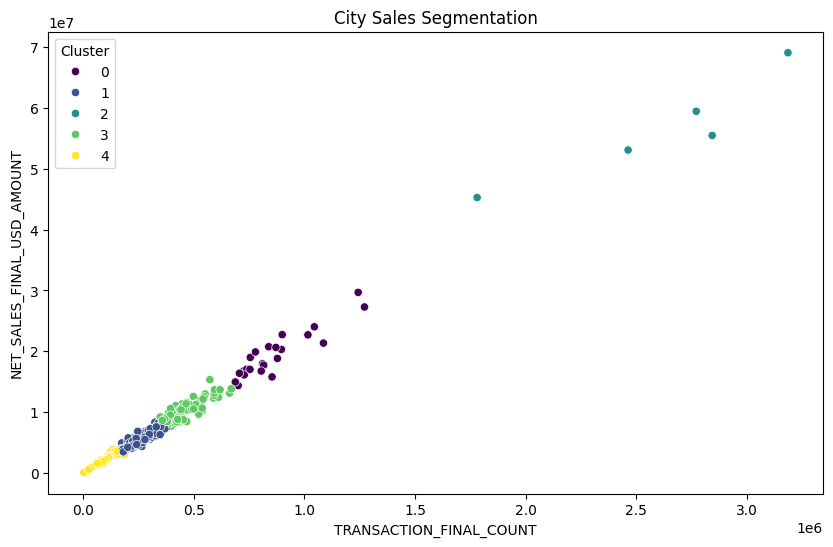

     CITY_NAME  Cluster
0      ABILENE        1
1        ALAMO        3
2  ALBUQUERQUE        3
3        ALLEN        3
4         AMES        1


In [127]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

state_stats = sales_city_datewise.groupby('CITY_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']

state_stats.rename(columns={'OPEN_DATE': 'NUM_OF_STORES'}, inplace=True)
state_stats.reset_index(inplace=True)

# Prepare data for clustering
city_data = state_stats[['CITY_NAME', 'TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT']]

# You can also scale the data if necessary, e.g., using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_data[['TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)  # Choose the number of clusters
city_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=city_data, x='TRANSACTION_FINAL_COUNT', y='NET_SALES_FINAL_USD_AMOUNT', hue='Cluster', palette='viridis')
plt.title('City Sales Segmentation')
plt.show()

# Display the clustered data
print(city_data[['CITY_NAME', 'Cluster']].head())


<ipython-input-10-71bdb8609528>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['Cluster'] = kmeans.fit_predict(scaled_data)


     CITY_NAME  Cluster
0      ABILENE        0
1        ALAMO        3
2  ALBUQUERQUE        1
3        ALLEN        3
4         AMES        2


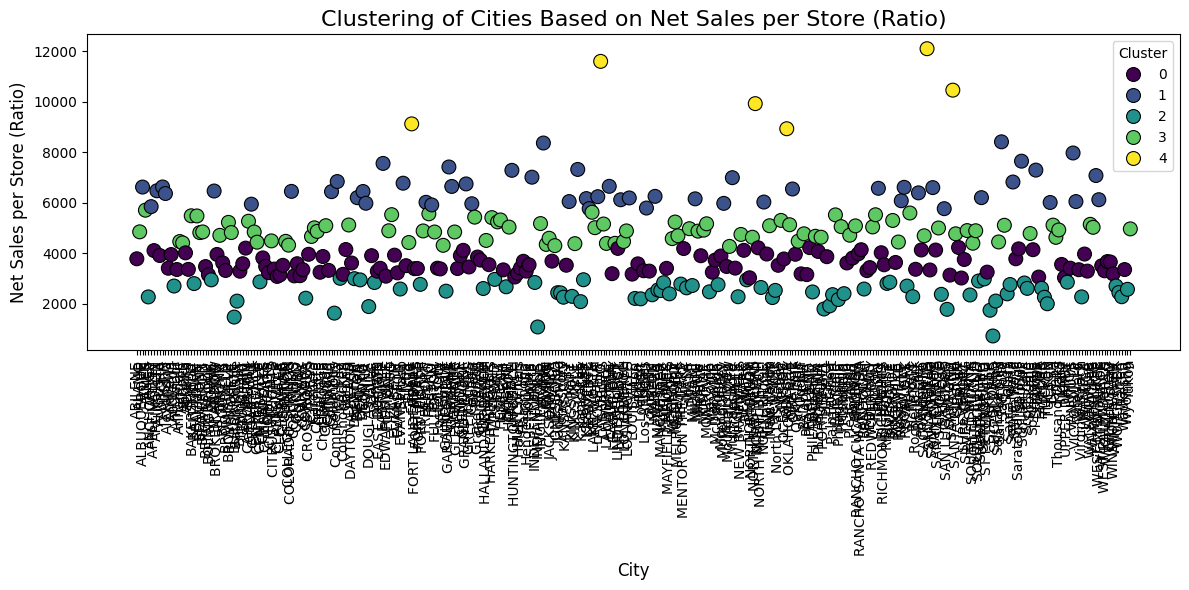

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'state_stats' DataFrame contains the relevant data (e.g., 'CITY_NAME', 'TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT')

# Assuming state_stats is already defined as a DataFrame with "STATE_NAME" as the index and "TRANSACTION_FINAL_COUNT" as a column
state_stats = sales_city_datewise.groupby('CITY_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['NET_SALES_FINAL_USD_AMOUNT'] / state_stats['OPEN_DATE']

#Rename "OPEN_DATE" column to "NUM_OF_STORES"
state_stats.rename(columns={'OPEN_DATE': 'NUM_OF_STORES'}, inplace=True)
state_stats.reset_index(inplace=True)

# Prepare data for clustering
city_data = state_stats[['CITY_NAME', 'ratio']]

# You can also scale the data if necessary, e.g., using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_data[['ratio']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)  # Choose the number of clusters
city_data['Cluster'] = kmeans.fit_predict(scaled_data)

import seaborn as sns

# Create a plot to visualize the clustering result
plt.figure(figsize=(12, 6))

# Scatter plot where x is CITY_NAME (categorical), y is the ratio, and color is based on clusters
sns.scatterplot(data=city_data, x='CITY_NAME', y='ratio', hue='Cluster', palette='viridis', s=100, edgecolor='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add titles and labels
plt.title('Clustering of Cities Based on Net Sales per Store (Ratio)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Net Sales per Store (Ratio)', fontsize=12)

# Display the plot
plt.tight_layout()
# Display the clustered data
print(city_data[['CITY_NAME', 'Cluster']].head())

In [175]:
city_data

CITY_NAME       ratio  Cluster
0        ABILENE  172.890898        1
1          ALAMO  220.584014        0
2    ALBUQUERQUE  261.619603        0
3          ALLEN  254.623104        0
4           AMES  120.971412        2
..           ...         ...      ...
343    WORCESTER  117.267211        2
344       Warren  112.768678        2
345     Waukesha  160.543165        1
346      Wyoming  120.238806        2
347        Yukon  208.941558        1

[348 rows x 3 columns]

In [177]:
city_data

CITY_NAME       ratio  Cluster
0        ABILENE  172.890898        3
1          ALAMO  220.584014        1
2    ALBUQUERQUE  261.619603        1
3          ALLEN  254.623104        1
4           AMES  120.971412        0
..           ...         ...      ...
343    WORCESTER  117.267211        0
344       Warren  112.768678        0
345     Waukesha  160.543165        3
346      Wyoming  120.238806        0
347        Yukon  208.941558        3

[348 rows x 3 columns]

In [11]:
!pip install geopy folium

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
import time


# Initialize the geolocator with increased timeout
geolocator = Nominatim(user_agent="store_locator", timeout=10)

# Function to get latitude and longitude with retries
def get_lat_lon(city):
    try:
        location = geolocator.geocode(city)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        print(f"Timeout error for {city}. Retrying...")
        time.sleep(1)
        return get_lat_lon(city)
    except Exception as e:
        print(f"Error for {city}: {e}")
        return None, None

# Get latitude and longitude for each city
city_data[['Latitude', 'Longitude']] = city_data['CITY_NAME'].apply(lambda x: pd.Series(get_lat_lon(x)))

# Drop rows with missing latitude or longitude
result_df = city_data.dropna(subset=['Latitude', 'Longitude'])


<ipython-input-11-a775cdf7d86b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[['Latitude', 'Longitude']] = city_data['CITY_NAME'].apply(lambda x: pd.Series(get_lat_lon(x)))


In [149]:

# Create a map centered around the first store's location
map_center = [result_df.iloc[0]['Latitude'], result_df.iloc[0]['Longitude']]
store_map = folium.Map(location=map_center, zoom_start=5)
colors = ['blue', 'red', 'orange','green', 'yellow']
cluster_names = ['Bad', 'Poor', 'Average', 'Good', 'Excellent']

# Add points to the map
for idx, row in result_df.iterrows():
    location = (row['Latitude'], row['Longitude'])
    tooltip = result_df.loc[idx, 'CITY_NAME']
    color = colors[row['Cluster']]
    city_name = row['CITY_NAME']
    cluster = row['Cluster']
    # Marker with a label
    folium.CircleMarker(location=location, radius=4, color=color, fill=True, tooltip=tooltip).add_to(store_map)

# Create a custom legend
legend_html = f'''
     <div style="position: fixed;
                 bottom: 30px; left: 30px; width: 200px; height: auto;
                 background-color: white; border:2px solid grey;
                 z-index:9999; font-size: 12px; font-weight: bold; padding: 10px;">
     <b>Cluster Legend</b><br>
     <i style="background: blue; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 0 - {cluster_names[0]}<br>
     <i style="background: red; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 1 - {cluster_names[1]}<br>
     <i style="background: orange; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 2 - {cluster_names[2]}<br>
     <i style="background: green; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 3 - {cluster_names[3]}<br>
     <i style="background: yellow; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 4 - {cluster_names[4]}
     </div>
     '''

# Add the legend to the map using the HTML element
store_map.get_root().html.add_child(folium.Element(legend_html))
    # folium.Marker(
    #     location=location,
    #     icon=folium.DivIcon(html=f'<div style="font-size: 10px; font-weight:400; color: {color}; bgcolor: white;">{cluster}</div>')
    # ).add_to(store_map)
# Save the map to an HTML file
# store_map.save('/content/drive/My Drive/store_map.html')

store_map

In [12]:

# Create a map centered around the first store's location
map_center = [result_df.iloc[0]['Latitude'], result_df.iloc[0]['Longitude']]
store_map = folium.Map(location=map_center, zoom_start=5)
colors = ['blue', 'red', 'orange','green', 'yellow']
colors = ['red', 'blue', 'green','red', 'yellow']
cluster_names = ['Bad', 'Poor', 'Average', 'Good', 'Excellent']
# cluster_names = ['Bad', 'Excellent', 'Average', 'Good', 'Poor']
# 0 4 2 3 1
# 2 0 3 1 4
# Add points to the map
for idx, row in result_df.iterrows():
    location = (row['Latitude'], row['Longitude'])
    tooltip = result_df.loc[idx, 'CITY_NAME']
    color = colors[row['Cluster']]
    city_name = row['CITY_NAME']
    cluster = row['Cluster']
    # Marker with a label
    folium.CircleMarker(location=location, radius=4, color=color, fill=True, tooltip=tooltip).add_to(store_map)

# Create a custom legend
legend_html = f'''
     <div style="position: fixed;
                 bottom: 30px; left: 30px; width: 200px; height: auto;
                 background-color: white; border:2px solid grey;
                 z-index:9999; font-size: 12px; font-weight: bold; padding: 10px;">
     <b>Cluster Legend</b><br>
     <i style="background: blue; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 0 - {cluster_names[0]}<br>
     <i style="background: red; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 1 - {cluster_names[1]}<br>
     <i style="background: orange; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 2 - {cluster_names[2]}<br>
     <i style="background: green; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 3 - {cluster_names[3]}<br>
     <i style="background: yellow; width: 20px; height: 20px; display: inline-block; border-radius: 50%;"></i> Cluster 4 - {cluster_names[4]}
     </div>
     '''

# Add the legend to the map using the HTML element
store_map.get_root().html.add_child(folium.Element(legend_html))
    # folium.Marker(
    #     location=location,
    #     icon=folium.DivIcon(html=f'<div style="font-size: 10px; font-weight:400; color: {color}; bgcolor: white;">{cluster}</div>')
    # ).add_to(store_map)
# Save the map to an HTML file
# store_map.save('/content/drive/My Drive/store_map.html')

store_map

In [13]:
# Add the legend to the map using the HTML element
store_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
file_path = 'normalised_clustering_map_with_legend.html'
store_map.save(file_path)

# Optionally print the file path
print(f"Map saved to {file_path}")


Map saved to normalised_clustering_map_with_legend.html


In [116]:
# fetch records where "Cluster" == 1
city_data[city_data['Cluster'] == 1]

CITY_NAME  TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  \
46       CHICAGO                  2843001                 55486498.49   
74        DALLAS                  2771047                 59464406.42   
130      HOUSTON                  3185495                 69095332.09   
172  LOS ANGELES                  2462911                 53090259.76   
278  SAN ANTONIO                  1780531                 45274994.29   

     Cluster   Latitude   Longitude  
46         1  41.875562  -87.624421  
74         1  32.776272  -96.796856  
130        1  29.758938  -95.367697  
172        1  34.053691 -118.242766  
278        1  29.424600  -98.495141

<ipython-input-15-12400df37af8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dma_data['Cluster'] = kmeans.fit_predict(scaled_dma_data)


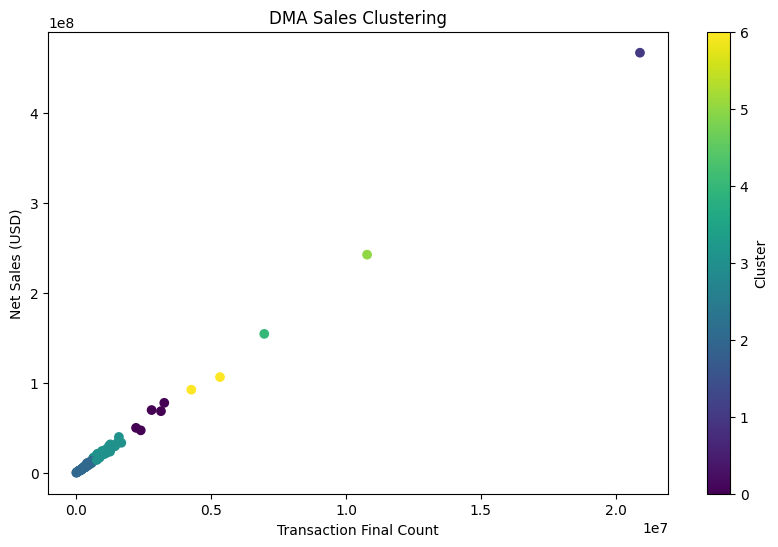

    DMA_ID  Cluster
0    501.0        6
1    503.0        2
2    504.0        3
3    505.0        3
4    506.0        3
..     ...      ...
93   839.0        3
94   855.0        3
95   862.0        3
96   866.0        3
97   881.0        2

[98 rows x 2 columns]


In [15]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

state_stats = sales_city_datewise.groupby('DMA_ID').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']

#Rename "OPEN_DATE" column to "NUM_OF_STORES"
state_stats.rename(columns={'OPEN_DATE': 'NUM_OF_STORES'}, inplace=True)
state_stats.reset_index(inplace=True)

# DMA-level data
dma_data = state_stats[['DMA_ID', 'TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT']]

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dma_data = scaler.fit_transform(dma_data[['TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=7)  # Choose the number of clusters
dma_data['Cluster'] = kmeans.fit_predict(scaled_dma_data)

# Visualize the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(dma_data['TRANSACTION_FINAL_COUNT'], dma_data['NET_SALES_FINAL_USD_AMOUNT'], c=dma_data['Cluster'], cmap='viridis')
plt.title('DMA Sales Clustering')
plt.xlabel('Transaction Final Count')
plt.ylabel('Net Sales (USD)')
plt.colorbar(label='Cluster')
plt.show()

# Display clustered DMA data
print(dma_data[['DMA_ID', 'Cluster']])


## DMA-Level Sales Optimization

* Use linear programming to optimize resource allocation across DMAs.
* Objective: The goal is to maximize the sales by optimally allocating resources (inventory) across different DMAs (Designated Market Areas), subject to certain constraints.
* Assume we're allocating a fixed amount of inventory across DMA regions
* Constraints: Total inventory across all DMAs should be within a limit
* Method: Optimization models (like linear programming) can help determine the best allocation of resources (e.g., inventory, promotions) across different DMAs.


 1. Maximize:

    Sales
    =
    ∑
    (
    Sales per unit of inventory allocated to DMA
    𝑖
    ×
    Inventory allocated to DMA
    𝑖
    )

2. Constraint:

    The inventory allocated to each DMA must not exceed the inventory limit for that DMA, i.e., for each DMA
    i:

    0
    ≤
    Inventory allocated to DMA
    𝑖
    ≤
    Inventory limit for DMA
    𝑖



In [16]:
dma_data

DMA_ID  TRANSACTION_FINAL_COUNT  NET_SALES_FINAL_USD_AMOUNT  Cluster
0    501.0                  4266295                 92327632.30        6
1    503.0                   475194                  8976678.36        2
2    504.0                   727594                 14937140.42        3
3    505.0                   849041                 17508007.62        3
4    506.0                  1437837                 29523251.00        3
..     ...                      ...                         ...      ...
93   839.0                  1555591                 34748359.74        3
94   855.0                   756440                 14440983.31        3
95   862.0                   993984                 22221066.92        3
96   866.0                   887408                 20267541.93        3
97   881.0                    52780                  1230277.28        2

[98 rows x 4 columns]

In [17]:
from scipy.optimize import linprog
import pandas as pd
import random

dma_data = state_stats[['DMA_ID', 'TRANSACTION_FINAL_COUNT', 'NET_SALES_FINAL_USD_AMOUNT']]



# Example inventory limits for each DMA (hypothetical)
# dma_inventory_limits = {
#     'DMA_1': 5000,
#     'DMA_2': 3000,
#     'DMA_3': 7000,
#     # Add more DMAs as needed
# }
dma_inventory_limits = {}
for dma_id in range(500, 883):
  dma_inventory_limits[dma_id] = random.randint(1000, 10000)

# Objective coefficients (e.g., sales per unit of inventory allocated to each DMA)
c = dma_data['NET_SALES_FINAL_USD_AMOUNT'].values

# Bounds for each DMA (maximum inventory limit per DMA)
bounds = [(0, dma_inventory_limits[dma]) for dma in dma_data['DMA_ID']]

# Linear programming optimization (maximize sales subject to inventory constraints)
result = linprog(-c, bounds=bounds, method='highs') # -c is the negated objective function (sales per DMA), so the algorithm will maximize the sales.

# Print results (optimal allocation of inventory to maximize sales)
print(f"Optimal resource allocation for each DMA: {result.x}")


Optimal resource allocation for each DMA: [6569. 5083. 7339. 7823. 3846. 6051. 3371. 6746. 4384. 7409. 9307. 2859.
 3958. 1337. 2124. 5306. 8839. 6847. 1757. 8652. 6538. 2317. 6524. 2779.
 4935. 1547. 2174. 8640. 6651. 7444. 8650. 9708. 5104. 9750. 8135. 9152.
 6947. 2161. 6726. 4419. 1290. 4697. 6579. 2934. 2866. 6933. 9519. 5457.
 4977. 4872. 6036. 6481. 5050. 5992. 7830. 3357. 5253. 7287. 3379. 4635.
 2836. 2330. 3180. 7726. 9610. 1712. 7929. 4881. 5327. 2066. 1042. 3600.
 2399. 5012. 7430. 2235. 8453. 8716. 6215. 9065. 4757. 3822. 7483. 4605.
 4161. 3431. 3953. 1425. 4471. 4510. 2358. 2335. 2712. 2053. 2758. 1792.
 1848. 9717.]


## Multi-Region Sales Comparison (ANOVA or Kruskal-Wallis Test)

In [173]:
import pandas as pd
import scipy.stats as stats


# state_stats = sales_city_datewise.groupby('CITY_NAME').agg({'TRANSACTION_FINAL_COUNT': 'sum', 'NET_SALES_FINAL_USD_AMOUNT': 'sum', 'OPEN_DATE': 'count'})
# state_stats['ratio'] = state_stats['TRANSACTION_FINAL_COUNT'] / state_stats['OPEN_DATE']

# state_stats.rename(columns={'OPEN_DATE': 'NUM_OF_STORES'}, inplace=True)
# state_stats.reset_index(inplace=True)

city_sales_data = sales_city_datewise[['STATE_NAME', 'NET_SALES_FINAL_USD_AMOUNT']]

groups = city_sales_data.groupby('STATE_NAME')['NET_SALES_FINAL_USD_AMOUNT'].apply(list)

# Perform one-way ANOVA to test if there are significant differences in sales across states
f_statistic, p_value = stats.f_oneway(*groups)

print(f"ANOVA Test Statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There are significant differences in sales across states.")
else:
    print("There are no significant differences in sales across states.")


ANOVA Test Statistic: 3151.4884495996516
P-value: 0.0
There are significant differences in sales across states.
